# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [109]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [110]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=False, 
    download=True,
    transform=transform
)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

10000
torch.Size([1, 28, 28]) 7


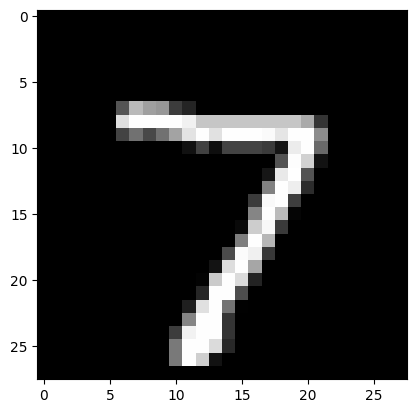

In [111]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [121]:
from torch.utils.data import Subset


batch_size = 256
# 0부터 47999까지는 훈련용, 48000부터 59999까지는 검증용으로 설정
train_indices = list(range(48000))
test_indices = list(range(48000, 60000))

train_dataset = Subset(trainset, train_indices)
test_dataset = Subset(trainset, test_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [122]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [123]:

import torch
import torch.nn.functional as F
from torch import nn




# Softmax, Cross-Entropy 손실 함수 정의 (PyTorch 사용)
class Model(nn.Module):
    def SoftmaxGD(trainloader, w, b, learning_rate=0.01, epoch=100):

        for e in range(epoch):
            total_loss = 0
            correct = 0
            total = 0

            for batch_idx, (x_batch, y_batch) in enumerate(trainloader):
                x_batch = x_batch.view(x_batch.size(0), -1)  # 28x28 이미지 -> 1차원 벡터로 변환
                y_batch_onehot = F.one_hot(y_batch, num_classes=10).float()  # 원-핫 인코딩
                
                # 예측값 계산
                z = torch.matmul(x_batch, w) + b
                pred = F.softmax(z, dim=1)

                # 손실 계산
                loss = F.cross_entropy(pred, y_batch_onehot)
                total_loss += loss.item()

                # 정확도 계산
                _, predicted = torch.max(pred, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

                # 기울기 계산 및 가중치 업데이트
                dz = (pred - y_batch_onehot) / x_batch.size(0)
                dw = torch.matmul(x_batch.t(), dz)
                db = dz.sum(0)

                w -= learning_rate * dw
                b -= learning_rate * db

            # 에포크마다 손실과 정확도 출력
            acc = correct / total
            avg_loss = total_loss / total
            print(f"Epoch {e+1}/{epoch}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")

        return w, b

# 가중치와 바이어스 초기화
w = torch.randn(28*28, 10, requires_grad=False)
b = torch.zeros(10, requires_grad=False)

# 학습 실행
w, b = SoftmaxGD(trainloader, w, b)




Epoch 1/100, Loss: 0.0368, Accuracy: 0.1017
Epoch 2/100, Loss: 0.0358, Accuracy: 0.1684
Epoch 3/100, Loss: 0.0347, Accuracy: 0.2360
Epoch 4/100, Loss: 0.0337, Accuracy: 0.3065
Epoch 5/100, Loss: 0.0328, Accuracy: 0.3711
Epoch 6/100, Loss: 0.0320, Accuracy: 0.4199
Epoch 7/100, Loss: 0.0314, Accuracy: 0.4640
Epoch 8/100, Loss: 0.0308, Accuracy: 0.4987
Epoch 9/100, Loss: 0.0304, Accuracy: 0.5279
Epoch 10/100, Loss: 0.0300, Accuracy: 0.5587
Epoch 11/100, Loss: 0.0296, Accuracy: 0.5803
Epoch 12/100, Loss: 0.0293, Accuracy: 0.5990
Epoch 13/100, Loss: 0.0291, Accuracy: 0.6174
Epoch 14/100, Loss: 0.0288, Accuracy: 0.6325
Epoch 15/100, Loss: 0.0286, Accuracy: 0.6464
Epoch 16/100, Loss: 0.0284, Accuracy: 0.6591
Epoch 17/100, Loss: 0.0283, Accuracy: 0.6705
Epoch 18/100, Loss: 0.0281, Accuracy: 0.6779
Epoch 19/100, Loss: 0.0280, Accuracy: 0.6873
Epoch 20/100, Loss: 0.0279, Accuracy: 0.6953
Epoch 21/100, Loss: 0.0277, Accuracy: 0.7032
Epoch 22/100, Loss: 0.0277, Accuracy: 0.7106
Epoch 23/100, Loss:

In [128]:
import torch
import torch.nn as nn
from torch.optim import SGD

# Model 클래스 정의
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 입력층 -> 은닉층
        self.fc2 = nn.Linear(hidden_size, output_size)  # 은닉층 -> 출력층
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # 28x28 이미지 -> 1차원 벡터로 변환
        x = self.fc1(x)  # 첫 번째 레이어 적용
        x = torch.relu(x)  # ReLU 활성화 함수
        x = self.fc2(x)  # 두 번째 레이어 적용
        return x

# 모델 초기화
input_size = 28 * 28  # MNIST 이미지 크기
hidden_size = 1024  # 은닉층 크기
output_size = 10  # MNIST 클래스 수

model = Model(input_size, hidden_size, output_size)



In [129]:
from torch.optim import SGD
# 옵티마이저 설정
lr = 0.001
model = model.to('cpu')

optimizer = SGD(model.parameters(), lr=lr)


In [130]:

train_accuracies = []
test_accuracies = []

In [131]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cpu'), labels.to('cpu')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt
  
  


In [132]:
n_epochs = 100

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cpu'), labels.to('cpu')

    preds = model(inputs)
    loss = (preds[:, 0] - labels).pow(2).mean()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)
    
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 1250.0412080287933
Epoch   1 | Loss: 703.6926231384277
Epoch   2 | Loss: 628.1207140684128
Epoch   3 | Loss: 583.9599719047546
Epoch   4 | Loss: 550.5981895923615
Epoch   5 | Loss: 524.424048781395
Epoch   6 | Loss: 503.6701822280884
Epoch   7 | Loss: 482.2856373786926
Epoch   8 | Loss: 463.97001922130585
Epoch   9 | Loss: 447.4146764278412
Epoch  10 | Loss: 431.12496316432953
Epoch  11 | Loss: 418.3969215154648
Epoch  12 | Loss: 404.528315782547
Epoch  13 | Loss: 391.0053473711014
Epoch  14 | Loss: 378.12608873844147
Epoch  15 | Loss: 366.6983071565628
Epoch  16 | Loss: 357.668820977211
Epoch  17 | Loss: 345.5146951675415
Epoch  18 | Loss: 336.6525365114212
Epoch  19 | Loss: 327.8406226634979
Epoch  20 | Loss: 319.19090473651886
Epoch  21 | Loss: 310.4266366958618
Epoch  22 | Loss: 303.4082729816437
Epoch  23 | Loss: 296.5268623828888
Epoch  24 | Loss: 288.89211332798004
Epoch  25 | Loss: 281.92232739925385
Epoch  26 | Loss: 275.6534314751625
Epoch  27 | Loss: 268.92

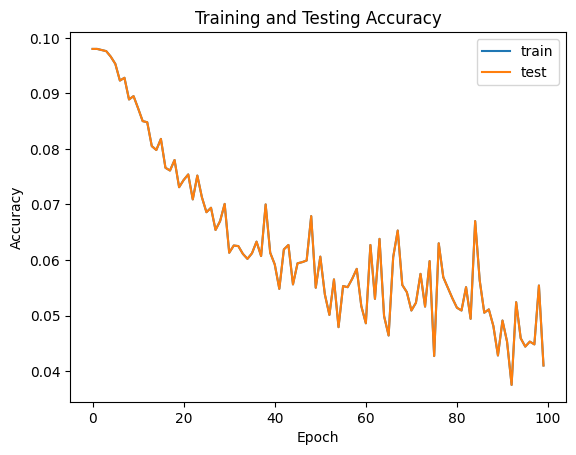

In [135]:
import numpy as np
import matplotlib.pyplot as plt  # matplotlib.pyplot 임포트 추가

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.xlabel('Epoch')  # x축 레이블 추가
    plt.ylabel('Accuracy')  # y축 레이블 추가
    plt.title('Training and Testing Accuracy')  # 제목 추가
    plt.legend()
    plt.show()

# plot_acc 함수 호출
plot_acc(train_accuracies, test_accuracies)
